# TensorFlow LSTM metrics
Model: TensorFlow LSTM

Dataset: electricity, exchange rate, solar_nips, traffic_nips

In this notebook we investigate the difference in evaulation scores when the same model is trained and tested multiple times with the same settings but different random seeds. We also explore if the best and worst seeds are consistently good or bad across all timeseries.

In [1]:
import matplotlib.pyplot as plt

from src.metrics import *

In [2]:
metric = ["MAPE"]
n = 10

In [3]:
def load_forecasts(experiment_path):
    repetitions = []
    for folder in sorted(os.listdir(experiment_path)):
        repetitions.append(pd.read_csv(f"{experiment_path}/{folder}/forecasts.csv", index_col=0).rename_axis("index"))
    return repetitions

In [4]:
def calculate_mape(repetitions, num_timeseries, num_windows=7, horizon=24):
    exp = []
    for rep in repetitions:
        array = rep[["target", "sample0"]].values
        array = array.reshape((num_timeseries * num_windows, horizon, 2))
        
        # Calculate MAPE like in GluonTS evaluator
        denominator = np.abs(array[:, :, 0])
        flag = denominator == 0
        mape = np.mean(np.abs((array[:, :, 0] - array[:, :, 1]) * (1 - flag)) / (denominator + flag), axis=1).reshape((-1, num_timeseries))

        metrics_df = pd.DataFrame(
            data=mape.reshape([-1, 1]),
            columns=["MAPE"]
            ).rename_axis("index")
        metrics_df["item_id"] = metrics_df.index % 321
        exp.append(metrics_df)
        
    return exp

### Exchange rate

In [5]:
experiment_path = "/datadrive/experiments/tf_lstm/exchange_rate/1B"
exp = load_forecasts(experiment_path)
exp = calculate_mape(exp, 8, 5, 30)

len(exp)

100

In [6]:
exp[0].head()

,MAPE,item_id
index,,
0,0.010823,0
1,0.005405,1
2,0.011801,2
3,0.008005,3
4,0.016171,4


In [7]:
report_experiment_results(exp, metric)

MAPE SCORES
	All seeds:
		Mean: 0.016840210651553646
		Std: 0.004257180726087394
		Variance: 0.06524707446382094

	Worst seeds:
		Mean: 0.026438403874635696
		Std: 0.0023372306022793055
		Variance: 0.04834491387009621

	Best seeds:
		Mean: 0.013214361853897572
		Std: 6.361742998706177e-05
		Variance: 0.007976053282618523




In [8]:
exp_array = calculate_timeseries_means(exp, metric, 8)
exp_array.shape

(100, 8, 1)

In [9]:
exp[0].head(10)

,MAPE,item_id
index,,
0,0.010823,0
1,0.005405,1
2,0.011801,2
3,0.008005,3
4,0.016171,4
5,0.015201,5
6,0.006001,6
7,0.011208,7
8,0.017351,8


(array([0., 0., 3., 0., 0., 3., 3., 0., 6., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
        3., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 7., 0., 0., 0., 0.,
        0., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 7., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        8., 5., 0., 7., 0., 0., 0., 0., 0., 0., 5., 5., 4., 0., 0.]),
 array([85, 63, 46, 88,  8, 96, 95, 52, 86, 97]),
 array([8., 7., 7., 7., 6., 5., 5., 5., 5., 4.]))

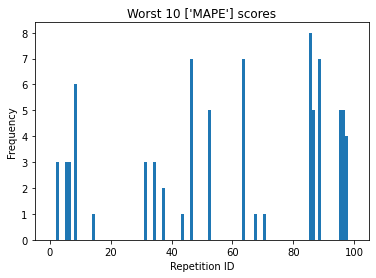

In [10]:
indexes_worst10, worst10 = np.unique(np.argsort(exp_array, axis=0)[-n:], return_counts=True)
worst_10_count = count_repetitions_among_top_n(indexes_worst10, worst10, exp_array.shape[0])
plt.title(f"Worst {n} {metric} scores")
plt.xlabel("Repetition ID")
plt.ylabel("Frequency")

plt.hist([i for i in range(exp_array.shape[0])], bins=exp_array.shape[0], range=(0, exp_array.shape[0]), weights=worst_10_count)

worst_10_count, np.argsort(worst_10_count)[-10:][::-1], worst_10_count[np.argsort(worst_10_count)[-10:][::-1]]

(array([1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 3., 3., 0., 1., 0., 2.,
        0., 1., 0., 3., 0., 2., 3., 3., 1., 0., 2., 1., 1., 0., 0., 2., 0.,
        0., 2., 1., 0., 1., 2., 2., 1., 2., 0., 1., 2., 0., 0., 1., 0., 0.,
        0., 0., 3., 1., 2., 2., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 3., 1., 0., 0., 0., 2., 3., 2., 0., 2., 0., 1., 1.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2.]),
 array([72, 78, 53, 11, 12, 24, 23, 20, 39, 77]),
 array([3., 3., 3., 3., 3., 3., 3., 3., 2., 2.]))

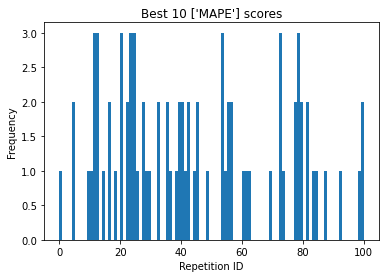

In [11]:
indexes_best10, best10 = np.unique(np.argsort(exp_array, axis=0)[:n], return_counts=True)
best_10_count = count_repetitions_among_top_n(indexes_best10, best10, exp_array.shape[0])
plt.title(f"Best {n} {metric} scores")
plt.xlabel("Repetition ID")
plt.ylabel("Frequency")

plt.hist([i for i in range(exp_array.shape[0])], bins=exp_array.shape[0], range=(0, exp_array.shape[0]), weights=best_10_count)

best_10_count, np.argsort(best_10_count)[-10:][::-1], best_10_count[np.argsort(best_10_count)[-10:][::-1]]

### Traffic nips

In [12]:
experiment_path = "/datadrive/experiments/tf_lstm/traffic_nips/1A"
exp = load_forecasts(experiment_path)
exp = calculate_mape(exp, 963)

len(exp)

100

In [13]:
report_experiment_results(exp, metric)

MAPE SCORES
	All seeds:
		Mean: 0.48121379996784525
		Std: 0.10962497662342549
		Variance: 0.3310966273211273

	Worst seeds:
		Mean: 0.7017747163772583
		Std: 0.2226427048444748
		Variance: 0.47185030579566956

	Best seeds:
		Mean: 0.38862428069114685
		Std: 0.011329678818583488
		Variance: 0.1064409613609314




In [14]:
exp_array = calculate_timeseries_means(exp, metric, 963)
exp_array.shape

(100, 963, 1)

(array([963.,   4.,   0., 420.,   0.,   3.,   0.,   0.,   6., 224.,   3.,
          1.,  59., 177., 240.,   0., 105.,   0., 367., 145.,   0., 553.,
          0.,  10.,   0., 142.,  22.,  12.,   0.,   0.,   0.,   2.,   0.,
          1.,  46.,   2.,   0.,   0.,   8.,   0.,  54.,   0.,   1.,   0.,
        331., 254.,   0.,   1.,   0.,   2.,  12.,   0.,  12.,   2.,   1.,
         10.,   3., 103., 961.,   2.,   0.,   5.,   7.,   0.,  16.,   0.,
          0.,   0.,   0.,  17.,   1., 872.,   1.,   0.,  56., 230.,   0.,
          0.,  80.,   0.,   1.,  17., 192.,   0.,   1.,   0., 354.,   0.,
        937.,  23., 168., 329.,  12.,   0.,   1., 325.,   0.,   0.,   9.,
        712.]),
 array([ 0, 58, 88, 71, 99, 21,  3, 18, 86, 44]),
 array([963., 961., 937., 872., 712., 553., 420., 367., 354., 331.]))

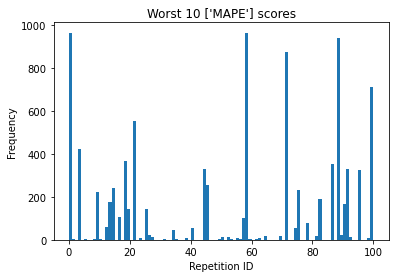

In [15]:
indexes_worst10, worst10 = np.unique(np.argsort(exp_array, axis=0)[-n:], return_counts=True)
worst_10_count = count_repetitions_among_top_n(indexes_worst10, worst10, exp_array.shape[0])
plt.title(f"Worst {n} {metric} scores")
plt.xlabel("Repetition ID")
plt.ylabel("Frequency")

plt.hist([i for i in range(exp_array.shape[0])], bins=exp_array.shape[0], range=(0, exp_array.shape[0]), weights=worst_10_count)

worst_10_count, np.argsort(worst_10_count)[-10:][::-1], worst_10_count[np.argsort(worst_10_count)[-10:][::-1]]

(array([  0.,  42., 137.,  44.,   5.,   1.,   4.,   6., 343.,   0.,   2.,
         58.,  17.,   1.,   3.,  53.,   4., 319.,  59.,   0.,  19.,   0.,
         10.,   2., 675.,   4.,   0.,   0., 109., 191., 386., 502., 119.,
         26.,  11.,  96.,  46., 437.,  47.,  48.,   8., 151.,  19., 179.,
          1.,  10.,   1.,  69.,  44., 243.,  33., 149.,   1.,   3.,   0.,
         19.,  43.,   0.,   2., 133.,  24.,   2.,   7., 449.,   0.,   0.,
         52., 377.,   5., 195.,   7.,   1., 273., 416.,   4.,   9.,  30.,
        169.,   1.,  82.,   9.,   0.,  16.,  34., 469., 597.,   4.,  57.,
          2.,  11.,   5.,   0.,   0., 699., 234.,   0.,  23.,  12., 421.,
          0.]),
 array([93, 24, 85, 31, 84, 63, 37, 98, 73, 30]),
 array([699., 675., 597., 502., 469., 449., 437., 421., 416., 386.]))

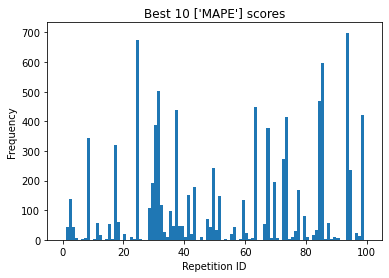

In [16]:
indexes_best10, best10 = np.unique(np.argsort(exp_array, axis=0)[:n], return_counts=True)
best_10_count = count_repetitions_among_top_n(indexes_best10, best10, exp_array.shape[0])
plt.title(f"Best {n} {metric} scores")
plt.xlabel("Repetition ID")
plt.ylabel("Frequency")

plt.hist([i for i in range(exp_array.shape[0])], bins=exp_array.shape[0], range=(0, exp_array.shape[0]), weights=best_10_count)

best_10_count, np.argsort(best_10_count)[-10:][::-1], best_10_count[np.argsort(best_10_count)[-10:][::-1]]

### Solar nips

In [17]:
experiment_path = "/datadrive/experiments/tf_lstm/solar_nips/1A"
exp = load_forecasts(experiment_path)
exp = calculate_mape(exp, 137)

len(exp)

100

In [18]:
report_experiment_results(exp, metric)

MAPE SCORES
	All seeds:
		Mean: 2.136826872663818
		Std: 0.22328842701001317
		Variance: 0.47253404851927144

	Worst seeds:
		Mean: 2.573117971420288
		Std: 0.05522850900888443
		Variance: 0.23500746488571167

	Best seeds:
		Mean: 1.773660659790039
		Std: 0.08279933035373688
		Variance: 0.2877487242221832




In [19]:
exp_array = calculate_timeseries_means(exp, metric, 137)
exp_array.shape

(100, 137, 1)

(array([  0.,   0., 123.,   1.,   0.,   0.,   0.,   0.,   0.,   4.,   3.,
          0.,   0.,   7.,  28.,   0.,   0.,   0.,   0.,   0.,   0.,   8.,
          0.,   0.,   0.,   0.,   0.,  66.,   0.,   0.,   0.,   4.,   0.,
          0.,   0.,   0.,   0.,   0.,  70.,   0.,  37.,   0.,  51.,   0.,
          0.,   1.,   1.,   0.,  42.,   0.,   0.,   0.,   0.,   0.,  38.,
        124.,  65.,   0.,   0.,   0.,   0.,   1.,   0.,  48.,   0.,   0.,
          0.,   0.,  19.,   0.,   0.,   0., 131.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,  14.,  90.,   2.,   0.,   0.,
          0., 102.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  88.,  91.,
        110.]),
 array([72, 55,  2, 99, 89, 98, 84, 97, 38, 27]),
 array([131., 124., 123., 110., 102.,  91.,  90.,  88.,  70.,  66.]))

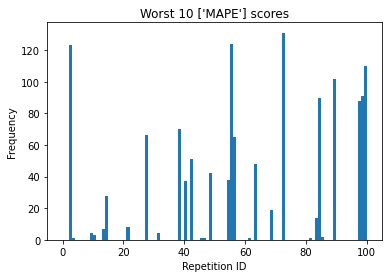

In [20]:
indexes_worst10, worst10 = np.unique(np.argsort(exp_array, axis=0)[-n:], return_counts=True)
worst_10_count = count_repetitions_among_top_n(indexes_worst10, worst10, exp_array.shape[0])
plt.title(f"Worst {n} {metric} scores")
plt.xlabel("Repetition ID")
plt.ylabel("Frequency")

plt.hist([i for i in range(exp_array.shape[0])], bins=exp_array.shape[0], range=(0, exp_array.shape[0]), weights=worst_10_count)

worst_10_count, np.argsort(worst_10_count)[-10:][::-1], worst_10_count[np.argsort(worst_10_count)[-10:][::-1]]

(array([  0., 103.,   0.,   0.,  44.,   0.,   0.,   6.,   0.,  16.,   0.,
          0.,   0.,   0.,  38.,   0.,  49.,   0.,   0.,  80.,   0.,   0.,
          0.,   0.,  37.,  21.,   0.,   0.,   0.,  90.,   0.,   0.,  19.,
          0.,   0.,   0.,  27.,   1.,   0.,  68.,  32., 117.,   0.,   0.,
          9.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  32.,  80.,   4.,
          0.,   0.,   0.,  75.,  39.,   1.,   0.,  42.,   0.,   0.,   0.,
         92.,   0.,  65.,   0.,  11.,  16.,   0.,   0.,   1.,   0., 118.,
          0.,   1.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   4.,   0.,  29.,   0.,   0.,   0.,   0.,
          0.]),
 array([76, 41,  1, 66, 29, 19, 53, 58, 39, 68]),
 array([118., 117., 103.,  92.,  90.,  80.,  80.,  75.,  68.,  65.]))

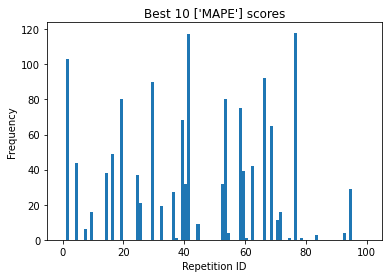

In [21]:
indexes_best10, best10 = np.unique(np.argsort(exp_array, axis=0)[:n], return_counts=True)
best_10_count = count_repetitions_among_top_n(indexes_best10, best10, exp_array.shape[0])
plt.title(f"Best {n} {metric} scores")
plt.xlabel("Repetition ID")
plt.ylabel("Frequency")

plt.hist([i for i in range(exp_array.shape[0])], bins=exp_array.shape[0], range=(0, exp_array.shape[0]), weights=best_10_count)

best_10_count, np.argsort(best_10_count)[-10:][::-1], best_10_count[np.argsort(best_10_count)[-10:][::-1]]

### Electricity

In [22]:
experiment_path = "/datadrive/experiments/tf_lstm/electricity/1B"
exp = load_forecasts(experiment_path)
exp = calculate_mape(exp, 321)

len(exp)

100

In [23]:
report_experiment_results(exp, metric)

MAPE SCORES
	All seeds:
		Mean: 0.29338058138307804
		Std: 0.055829267743541945
		Variance: 0.23628217821821

	Worst seeds:
		Mean: 0.4067157208919525
		Std: 0.06600657850503922
		Variance: 0.25691744685173035

	Best seeds:
		Mean: 0.2285086214542389
		Std: 0.0042366706766188145
		Variance: 0.06508971005678177




In [24]:
exp_array = calculate_timeseries_means(exp, metric, 321)
exp_array.shape

(100, 321, 1)

(array([  0.,   1.,   1., 175.,  23.,   0.,   8.,   0.,   0.,   1.,   0.,
        134.,   6.,   0.,   0.,   0.,  48.,   0.,   0.,   0.,   0.,   0.,
          5.,   0.,   0.,   0., 291.,   1.,   1.,  67.,   1.,  13.,   1.,
        233.,   0.,  98.,   7.,   2.,   0.,   0.,   1.,   0., 185., 166.,
         61.,  29., 135.,  82.,   0.,  50.,  35.,   0., 165.,   0.,  38.,
          4.,   0.,   0.,   0.,   0.,  38.,   0.,   0.,   3.,   0.,   1.,
          1.,   0., 108., 117.,   0.,   0.,   0.,   0., 306.,   0.,   0.,
          0.,  46.,   6.,  72., 181.,  33.,  18.,  14.,   0.,   0., 145.,
          4.,   0.,   0.,   0.,   5.,  10.,   6.,   1.,  26.,   0.,   0.,
          1.]),
 array([74, 26, 33, 42, 81,  3, 43, 52, 87, 46]),
 array([306., 291., 233., 185., 181., 175., 166., 165., 145., 135.]))

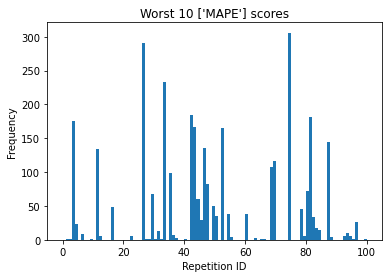

In [25]:
indexes_worst10, worst10 = np.unique(np.argsort(exp_array, axis=0)[-n:], return_counts=True)
worst_10_count = count_repetitions_among_top_n(indexes_worst10, worst10, exp_array.shape[0])
plt.title(f"Worst {n} {metric} scores")
plt.xlabel("Repetition ID")
plt.ylabel("Frequency")

plt.hist([i for i in range(exp_array.shape[0])], bins=exp_array.shape[0], range=(0, exp_array.shape[0]), weights=worst_10_count)

worst_10_count, np.argsort(worst_10_count)[-10:][::-1], worst_10_count[np.argsort(worst_10_count)[-10:][::-1]]

(array([  2.,  71.,   0.,   2.,  28.,  18.,   1.,  35.,  98.,   3., 189.,
         10.,  29.,   2.,   2.,  14.,   7.,  20.,   4.,  18., 160., 116.,
         34.,  63.,  10.,  23.,   3.,  26.,  37.,  26.,  18.,   1.,  76.,
         10.,  13.,   4.,   1.,   3., 175., 109., 152.,  23.,  24.,  25.,
         10.,  28.,   0.,   4., 216.,   2.,  26.,   4.,  17.,  32.,  10.,
          0.,   2., 150.,  32.,  15.,  15.,  20.,   2.,   2.,   3.,   9.,
         23.,  55.,  22.,   1.,   3.,  34.,  54.,   0.,   2.,  45.,  97.,
         60.,  24.,  44.,  35.,   0.,   1.,  14.,   9.,   2.,  35.,  26.,
         25.,   0., 164.,   6.,   0.,   1.,   6.,   0.,   2.,  42.,  16.,
         78.]),
 array([48, 10, 38, 90, 20, 40, 57, 21, 39,  8]),
 array([216., 189., 175., 164., 160., 152., 150., 116., 109.,  98.]))

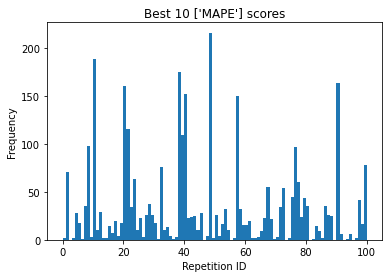

In [26]:
indexes_best10, best10 = np.unique(np.argsort(exp_array, axis=0)[:n], return_counts=True)
best_10_count = count_repetitions_among_top_n(indexes_best10, best10, exp_array.shape[0])
plt.title(f"Best {n} {metric} scores")
plt.xlabel("Repetition ID")
plt.ylabel("Frequency")

plt.hist([i for i in range(exp_array.shape[0])], bins=exp_array.shape[0], range=(0, exp_array.shape[0]), weights=best_10_count)

best_10_count, np.argsort(best_10_count)[-10:][::-1], best_10_count[np.argsort(best_10_count)[-10:][::-1]]